# Configuration 

* [The Active config](#The-Active-Config)
* [Creating a new Config](#Creating-a-new-Config)
* [Validation](#Validation)
* [Making customizations persistent across sessions](#Making-customizations-persistent-across-sessions)
* [The active Workspace](#The-active-Workspace)
* [Ad-hoc config](#Ad-hoc-config)


---------------

## The Active Config

Within *maelzel.core* **there is, at any moment, an active config object** (an instance of `CoreConfig`). This config encompasses settings related to notation, playback, quantization and many other aspects of *maelzel.core*. It is a subclass of *dict* with a fixed set of possible keys

In [1]:
from maelzel.core import *
from pitchtools import *

# Get the active config
conf = getConfig()
conf

Key,Value,Type,Descr
A4,442,between 10 - 10000,"Freq. of the Kammerton A4. Normal values are 440, 442, 443 or 432 for old tuning, but any 'fantasy' value can be used"
splitAcceptableDeviation,4,type: int,"When splitting notes between staves, notes within this range of the split point will be grouped together if they all fit"
chordAdjustGain,True,type: bool,"Adjust the gain of a chord according to the number of notes, to prevent clipping"
reprShowFreq,False,type: bool,Show frequency when printing a Note in the console
semitoneDivisions,4,"{1, 2, 4}","The number of divisions per semitone (2=quarter-tones, 4=eighth-tones)"
musescorepath,,type: str,The command to use when calling MuseScore. For macOS users: it must be an absolute path pointing to the actual binary inside the .app bundle
reprShowFractionsAsFloat,True,type: bool,"All time offsets and durations are kept as rational numbers to avoid rounding errors. If this option is True, these fractions are printed as floats in order to make them more readable."
jupyterHtmlRepr,True,type: bool,"If True, output html inside jupyter as part of the _repr_html_ hook. Under certain circumstances (for example, when generating documentation from a notebook) this html might result in style conflict. Setting in False will just output plain text"
fixStringNotenames,False,type: bool,"If True, pitches given as string notenames are fixed at the spelling given at creation. Otherwise pitches might be respelled to match their context for better readability. Pitches given as midi notes or frequencies are always respelled"
openImagesInExternalApp,False,type: bool,"Force opening images with an external tool, even when inside a Jupyter notebook"


**The config is a subclass of dict where only a well defined set of keys are allowed and values are validated**.

All operations on a built-in dict can be performed. 


## Creating a new Config

To create a new configuration you can simply call `CoreConfig()` to get a copy of the default config.

As an example, here we **create a new config** with a custom reference frequency. This modifies the reference frequency for any operation converting frequency to midinote or note name. After evaluating the following cell one can confirm that a frequency of 442 Hz is now 12 cents lower than A4

In [3]:
conf = CoreConfig({'A4': 445}, active=True)

# Diff show the differences with the default config
conf.diff()

{'A4': 445, 'play.instr': 'piano'}

In [4]:
f2n(442)

'4A-12'

To restore the original frequency, just modify the value of the active config:

In [5]:
getConfig()['A4'] = 442
f2n(442)

'4A'

Or activate the previous config

In [6]:
conf.activate()
f2n(442)

'4A'

-----------------

## Validation

A `CoreConfig` is always valid (it is aware about valid values for its keys). For example, it is possible to customize the number of playback channels used by the sound engine, or the latency used for scheduling events. 

In [7]:
# Set the default number of channels for playback. Any playback engine created will use this setting
conf['play.numChannels'] = 4
conf['play.schedLatency'] = 0.1

A wrong type or range will throw an error and the previous value will not be overwritten so that the configuration remains in a usable state.

In [8]:
conf['play.numChannels'] = 'four'

ValueError: Expected int for key play.numChannels, got str

## Making customizations persistent across sessions

Customizations can be made persistent by calling `save` on the dictionary (independently of it being active). After that, any config created in a future session will use this dict as its prototype

In [5]:
conf.save()

To revert a config to its factory defaults, use `reset`. Call `save` to make the reset persistent.

In [8]:
conf.reset()
conf['play.numChannels']

2

## Customizing playback / recording

By default any `Note`/`Chord` is played back using the default preset. It is possible to customize this default preset: 

In [11]:
defPresetSoundfont("accordion", "/home/em/Lib/snd/sf2/Accordion.sf2")

Preset: accordion  
    routing=True, properties={'sfpath': '/home/em/Lib/snd/sf2/Accordion.sf2'}
  init: iSfTable_ sfloadonce "/home/em/Lib/snd/sf2/Accordion.sf2"

  ipresetidx sfPresetIndex "/home/em/Lib/snd/sf2/Accordion.sf2", 0, 0
  inote0_ = round(p(idataidx_ + 1))
  ivel_ = p(idataidx_ + 2) * 127
  aout1, aout2 sfplay ivel_, inote0_, kamp/16384, mtof:k(kpitch), ipresetidx, 1

  epilogue:
    turnoffWhenSilent aout1

In [12]:
conf['play.instr'] = 'accordion'

We create a simple chromatic scale to have something to play with

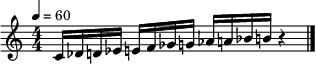

OfflineRenderer(sr=44100)
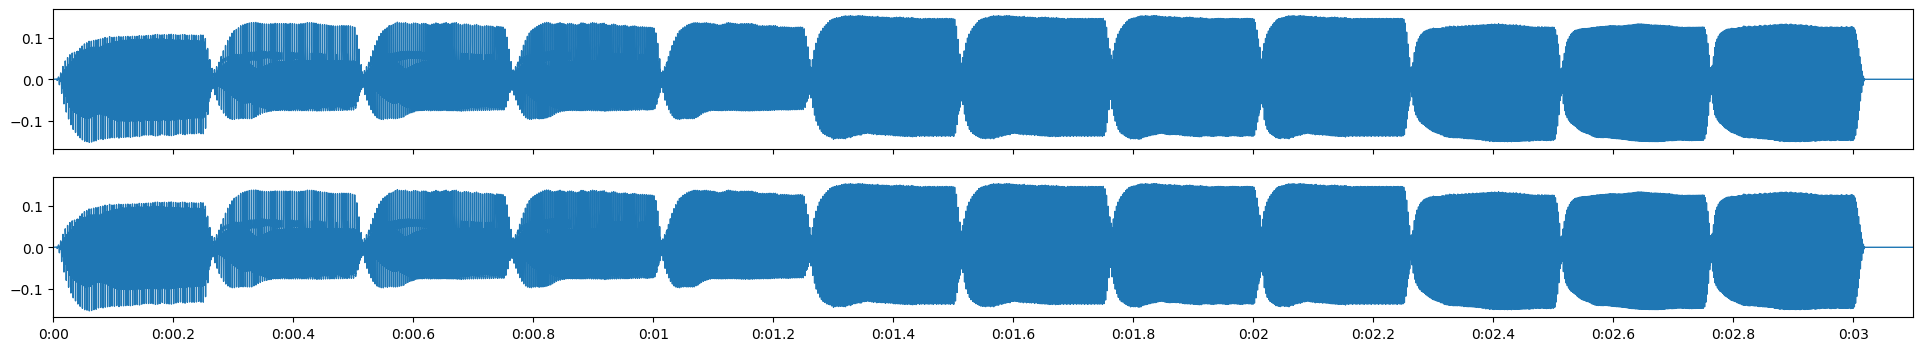

In [13]:
scale = Chain([Note(m, dur=0.25) for m in range(60, 72)])
scale.show()
scale.rec(extratime=0.1)

OfflineRenderer(sr=48000)
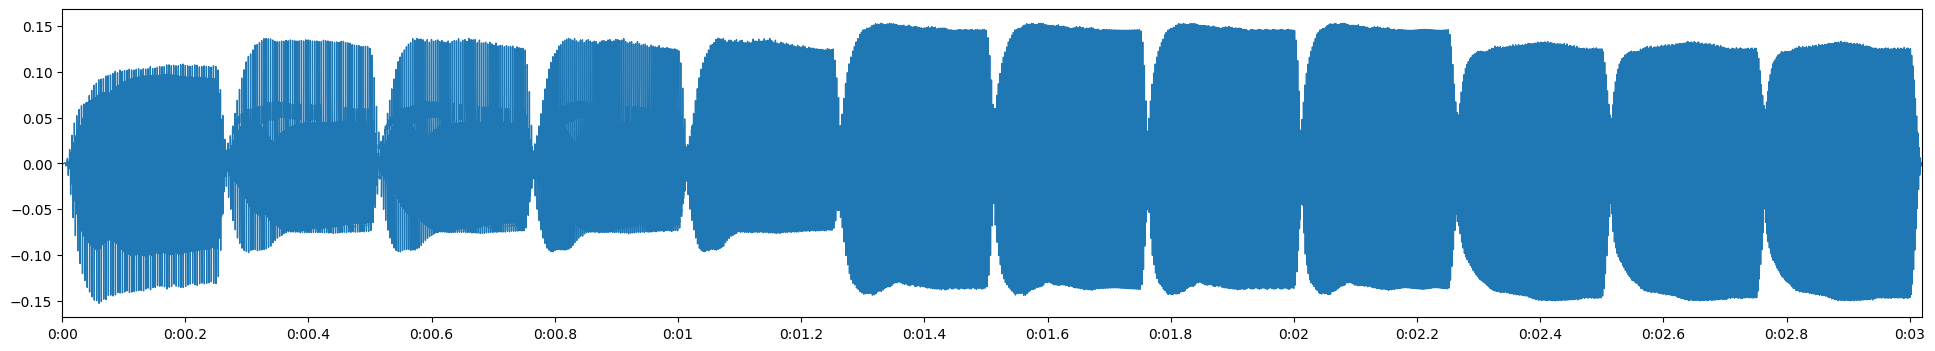

In [16]:
conf['rec.sr'] = 48000     # set default recording samplerate
scale.rec(nchnls=1)

----------------



## The active Workspace

At any moment there is one (and only one) active workspace. Whenever a config is made active, it is assigned to the active Workspace

A workspace contains the following attributes:

* `.config` (`CoreConfig`): a config 
* `.scorestruct` (`ScoreStruct`): a score structure 
* `.dynamicCurve`: a dynamics curve, mapping dynamics to amplitudes
* internal attributes which determine the current state

In [17]:
w = getWorkspace()
w

Workspace(scorestruct=ScoreStruct(tempo=60, timesig=(4, 4)), config={'play.instr': 'accordion', 'play.numChannels': 4, 'play.schedLatency': 0.1, 'rec.sr': 48000, 'quant.minBeatFractionAcrossBeats': 0.3333333333333333}, dynamicCurve=DynamicCurve(shape=expon(0.3), mindb=-60.0, maxdb=0.0))

In [18]:
if w.isActive():
    print("This is the active workspace")

if w.config is getConfig():
    print("Its config is active")
    

This is the active workspace
Its config is active


## Ad-hoc config

It is possible to create a config to perform only one specific set of actions. This is accomplished by using a `CoreConfig` as **context manager**

OfflineRenderer(sr=44100)
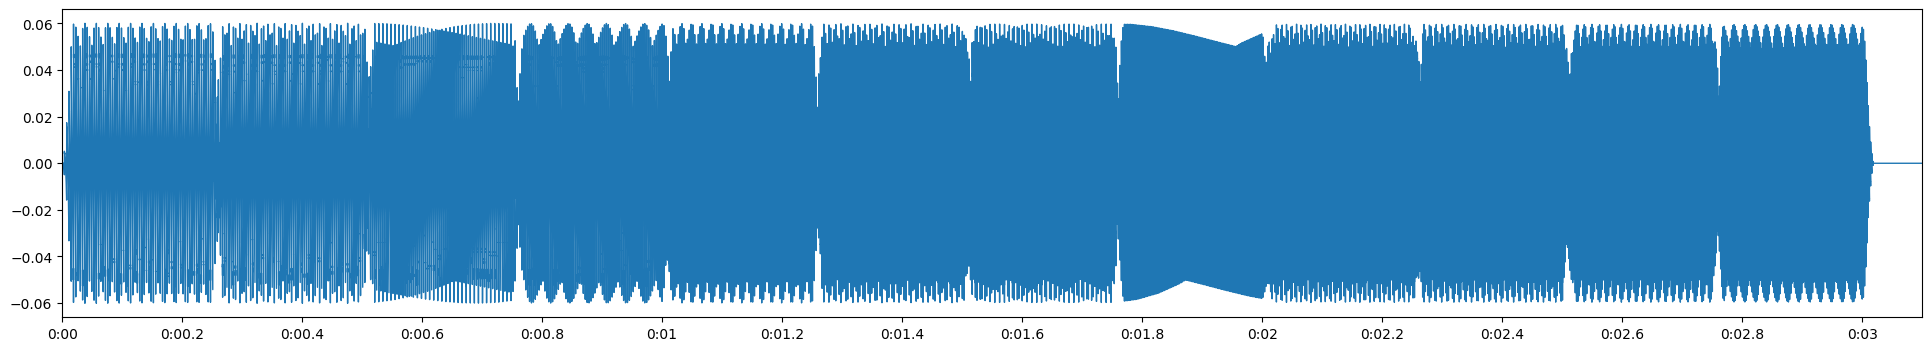

OfflineRenderer(sr=48000)
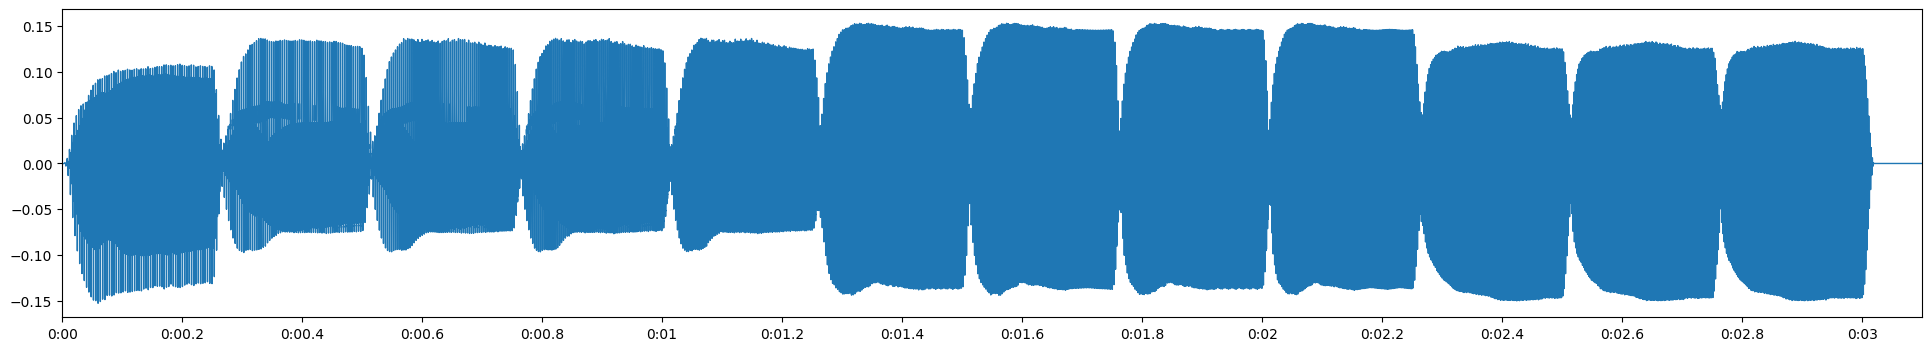

In [19]:
scale = Chain([Note(m, dur=0.25) for m in range(60, 72)])

with CoreConfig({'play.instr': 'saw'}):
    scale.rec(gain=0.1, nchnls=1, extratime=0.1).show()

# Outside the context the instr uses the previous default
scale.rec(nchnls=1, extratime=0.1)